In [1]:
import pandas as pd
import numpy as np
from treelib import Node, Tree
import matplotlib.pyplot as plt

In [2]:
def determine_candidate_numeric_splits(df, feature):
    """
    df: dataframe - of features and labels
    feature: string - with the column name of the desired feature for candidate splits
    
    candidate_splits: list of floats - where df should be splited
    """
    sorted_data = df.sort_values(feature).to_dict('records')

    prev_y = sorted_data[0]['y']
    candidate_splits = []
    for data_point in sorted_data:
        if data_point['y'] != prev_y:
            candidate_splits.append(prev_x)
        prev_y = data_point['y']
        prev_x = data_point[feature]
        
    return candidate_splits


In [3]:
def get_entropy(df_array):
    """
    df_array: pandas series
    
    entropy: float - entropy of df_array
    """
    probs = df_array.value_counts(normalize=True).values
    entropy = sum(-probs*np.log2(probs))
    return entropy

def get_info_gain_ratios(df, feature, splits):
    """
    df: dataframe - with all data
    feature: string - column name of df to get the info gain ratios
    splits: list of float - cadidate splits for which to compute info gain ratio
    
    
    info_gain_ratios: list of floats - info gain ratio for every candidate split
    """
    
    # calculate H(Y)
    H_y = get_entropy(df['y'])
    
    info_gain_ratios = []
    for split in splits:
        #calculate H(Y|X)
        left_branch_data = df[feature] <= split
        H_y_xl = get_entropy(df[left_branch_data]['y'])
        H_y_xr = get_entropy(df[~left_branch_data]['y'])
        H_y_x = H_y_xl*(left_branch_data).mean() + H_y_xr*(~left_branch_data).mean()
        
        # calculate H(S)
        H_x = get_entropy(left_branch_data)

        if H_x == 0:
            info_gain_ratio = 0
        else:
            info_gain_ratio = (H_y - H_y_x)/H_x
        info_gain_ratios.append(info_gain_ratio)
                         
    return info_gain_ratios

In [4]:
def stoping_criteria(splits, info_gain):
    """
    splits: list of float - cadidate splits for which to compute info gain ratio
    info_gain: list of floats - info gain ratio for every candidate split
    
    boolean - if the tree should stop building
    
    stoping criteria is if there are no candidate splits or if there is no information gain of any split
    """
    no_splits = len(splits) == 0
#     print(no_splits)
    no_info_gain = all(np.array(info_gain) == 0) #or all(np.isnan(np.array(info_gain)))
#     print(no_info_gain)
    return no_splits or no_info_gain

In [5]:
def find_best_split(splits_gains):
    """
    splits_gains: dict: {feature: {info_gain:list, splits: list}}
    
    tuple: (feature, best_split)
    
    chooses the best feature and the value for maximizing info gain ratio
    """
    best_splits = {}
    for feature, split_gain in splits_gains.items():
        max_gain = max(split_gain['info_gain'])
        index_max_gain = split_gain['info_gain'].index(max_gain)
        best_candidate = split_gain['splits'][index_max_gain]
        best_splits[feature] = {'max_gain':max_gain, 'best_candidate':best_candidate}
        
    if best_splits['x0']['max_gain'] > best_splits['x1']['max_gain']:
        return 'x0', best_splits['x0']['best_candidate']
    return 'x1', best_splits['x1']['best_candidate']

In [6]:
def make_subtree(df, tree, node='data', parent_node=None):
    """
    df: dataframe - all data to create a tree
    tree: treelib.tree.Tree instance
    node: string - name (id) of node to create
    parent_node: string - name (id) of node to which attach the created node
    
    tree: treelib.tree.Tree instance grown
    """
    
    features = ['x0', 'x1']
    splits_gains = {}
    for feature in features:
        splits = determine_candidate_numeric_splits(df, feature)
        info_gain = get_info_gain_ratios(df, feature, splits)
        splits_gains[feature] = {'splits': splits, 'info_gain':info_gain}

    all_splits = splits_gains['x0']['splits'] + splits_gains['x1']['splits']
    all_info_gain = splits_gains['x0']['info_gain'] + splits_gains['x1']['info_gain']
    
    if stoping_criteria(all_splits, all_info_gain):
        # create leaf node
        label = df['y'].value_counts().index[0]
        tree.create_node(str(label), node, parent=parent_node) 
    else:
        # create node
        tree.create_node('', node, parent=parent_node) 
    
        # set parameters for next node
        feature, best_candidate = find_best_split(splits_gains)
        future_node_0 = '{} <= {}'.format(feature, best_candidate)
        future_node_1 = '{} > {}'.format(feature, best_candidate)
        
        # for every branch in the tree -> make subtree
        child = make_subtree(df[df[feature] <= best_candidate], tree, future_node_0, node)
        child = make_subtree(df[df[feature] > best_candidate], tree, future_node_1, node)
        
    return tree

In [8]:
ls data

D1.txt        D2.txt        D3leaves.txt  Dbig.txt      Druns.txt


In [9]:
df = pd.read_csv('data/D3leaves.txt', sep=' ', header=None, names=['x0', 'x1', 'y'])
tree = Tree()
tree = make_subtree(df, tree)

In [10]:
tree.show(idhidden=False)

[data]
├── [x1 <= 1]
│   ├── 0[x0 <= 1]
│   └── 1[x0 > 1]
└── 1[x1 > 1]



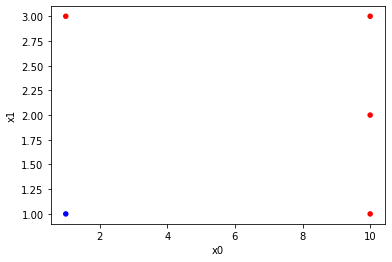

In [13]:
col = df['y'].map({0:'b', 1:'r'})
df.plot.scatter('x0', 'x1', c=col, alpha=1);

# Part 2

#### QUESTION 2

In [9]:
x0 = [0, 0, 1, 1]
x1 = [0, 0, 0, 0]
y = [0, 1, 0, 1]

df = pd.DataFrame([x0, x1, y]).T.rename({0:'x0', 1:'x1', 2:'y'}, axis=1)

In [10]:
df

,x0,x1,y
0,0,0,0
1,0,0,1
2,1,0,0
3,1,0,1


In [11]:
tree = Tree()
tree = make_subtree(df, tree)
tree.show(idhidden=False)

0[data]



In [12]:
tree = Tree()
tree = make_subtree(df.iloc[[0,3]], tree)
tree.show(idhidden=False)

tree = Tree()
tree = make_subtree(df.iloc[[1,2]], tree)
tree.show(idhidden=False)

[data]
├── 0[x0 <= 0]
└── 1[x0 > 0]

[data]
├── 0[x0 > 0]
└── 1[x0 <= 0]



#### QUESTION 3

In [13]:
df = pd.read_csv('data/Druns.txt', sep=' ', header=None, names=['x0', 'x1', 'y'])

feature = 'x0'
splits = determine_candidate_numeric_splits(df, feature)
info_gain = get_info_gain_ratios(df, feature, splits)
temp = pd.DataFrame([splits, info_gain], index=['candidate_split', 'info_gain_ratio']).T
print('for feature: {}'.format(feature))
display(temp.drop_duplicates())

feature = 'x1'
splits = determine_candidate_numeric_splits(df, feature)
info_gain = get_info_gain_ratios(df, feature, splits)
temp = pd.DataFrame([splits, info_gain], index=['candidate_split', 'info_gain_ratio']).T
print('for feature: {}'.format(feature))
display(temp.drop_duplicates())

for feature: x0


,candidate_split,info_gain_ratio
0,0.0,0.100518


for feature: x1


,candidate_split,info_gain_ratio
0,-2.0,0.100518
1,-1.0,0.055954
2,5.0,0.236100
3,6.0,0.055954
4,7.0,0.430157


#### QUESTION 4

In [14]:
df = pd.read_csv('data/D3leaves.txt', sep=' ', header=None, names=['x0', 'x1', 'y'])
tree = Tree()
tree = make_subtree(df, tree, 'root', None)
tree.show(idhidden=False)
for leave in tree.paths_to_leaves():
    print(leave, '->',tree.get_node(leave[-1]).tag)

[root]
├── [x1 <= 1]
│   ├── 0[x0 <= 1]
│   └── 1[x0 > 1]
└── 1[x1 > 1]

['root', 'x1 <= 1', 'x0 <= 1'] -> 0
['root', 'x1 <= 1', 'x0 > 1'] -> 1
['root', 'x1 > 1'] -> 1


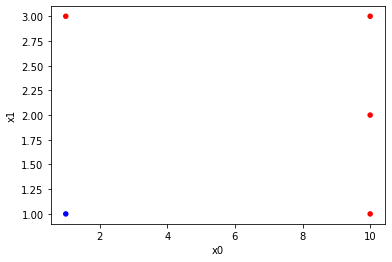

In [15]:
col = df['y'].map({0:'b', 1:'r'})
df.plot.scatter('x0', 'x1', c=col, alpha=1);

#### QUESTION 5

In [16]:

file = 'data/D1.txt'
df = pd.read_csv(file, sep=' ', header=None, names=['x0', 'x1', 'y'])
tree = Tree()
tree = make_subtree(df, tree, 'root', None)
# tree.save2file('tree_'+file.split('/')[1], idhidden=False)
tree.show(idhidden=False)

[root]
├── 0[x1 <= 0.199725]
└── 1[x1 > 0.199725]



In [17]:
file = 'data/D2.txt'
df = pd.read_csv(file, sep=' ', header=None, names=['x0', 'x1', 'y'])
tree = Tree()
tree = make_subtree(df, tree, 'root', None)
# tree.save2file('tree_'+file.split('/')[1], idhidden=False)
tree.show(idhidden=False)

[root]
├── [x0 <= 0.532664]
│   ├── [x1 <= 0.884872]
│   │   ├── [x1 <= 0.690829]
│   │   │   ├── [x1 > 0.532684]
│   │   │   │   ├── [x0 <= 0.417579]
│   │   │   │   │   ├── [x0 <= 0.409387]
│   │   │   │   │   │   ├── [x0 > 0.387288]
│   │   │   │   │   │   │   ├── 0[x1 <= 0.58882]
│   │   │   │   │   │   │   └── 1[x1 > 0.58882]
│   │   │   │   │   │   └── 0[x0 <= 0.387288]
│   │   │   │   │   └── [x0 > 0.409387]
│   │   │   │   │       ├── 0[x1 <= 0.570223]
│   │   │   │   │       └── 1[x1 > 0.570223]
│   │   │   │   └── 1[x0 > 0.417579]
│   │   │   └── 0[x1 <= 0.532684]
│   │   └── [x1 > 0.690829]
│   │       ├── [x0 <= 0.253723]
│   │       │   ├── [x0 <= 0.189016]
│   │       │   │   ├── [x1 > 0.860277]
│   │       │   │   │   ├── 0[x1 > 0.864128]
│   │       │   │   │   └── 1[x1 <= 0.864128]
│   │       │   │   └── 0[x1 <= 0.860277]
│   │       │   └── [x0 > 0.189016]
│   │       │       ├── 0[x1 <= 0.782804]
│   │       │       └── 1[x1 > 0.782804]
│   │       └── 1[x0 > 0.2537

#### QUESTION 6

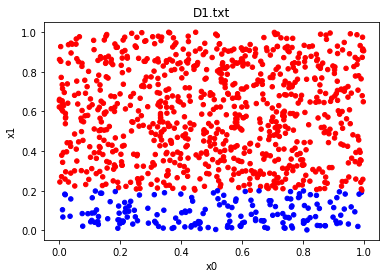

In [18]:
file = 'data/D1.txt'
df = pd.read_csv(file, sep=' ', header=None, names=['x0', 'x1', 'y'])

col = df['y'].map({0:'b', 1:'r'})
df.plot.scatter('x0', 'x1', c=col, alpha=1)
plt.title(file.split('/')[1])
plt.savefig('plot_'+file.split('/')[1].split('.')[0]+'.png')
plt.show();

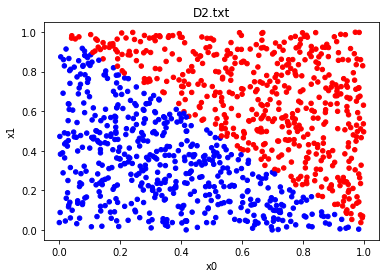

In [19]:
file = 'data/D2.txt'
df = pd.read_csv(file, sep=' ', header=None, names=['x0', 'x1', 'y'])

col = df['y'].map({0:'b', 1:'r'})
df.plot.scatter('x0', 'x1', c=col, alpha=1)
plt.title(file.split('/')[1])
plt.savefig('plot_'+file.split('/')[1].split('.')[0]+'.png')
plt.show();

In [20]:
def get_pred(tree, df_test):
    for leaf in tree.leaves():
        ex = df_test
        # getting filter criterias from tree
        instr = [i for i in tree.rsearch(leaf.identifier)][:-1]
        #filtering from each instruction
        for subset in instr[::-1]:
            feature, eq, value = subset.split(' ')
            if eq == '<=':
                ex = ex[ex[feature] <= float(value)]
            else:
                ex = ex[ex[feature] > float(value)]
        # setting filtered values the corresponding label
        df_test.loc[ex.index, 'pred'] = int(leaf.tag)
        
    return df_test

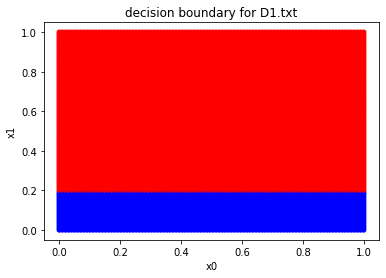

In [21]:
new_poins = []
for i in np.linspace(0, 1, 100):
    for j in np.linspace(0, 1, 100):
        new_poins.append((i, j))
pred = pd.DataFrame(new_poins, columns = ['x0', 'x1'])

file = 'data/D1.txt'
df = pd.read_csv(file, sep=' ', header=None, names=['x0', 'x1', 'y'])
tree = Tree()
tree = make_subtree(df, tree, 'root', None)

pred = get_pred(tree, pred)
col = pred['pred'].map({0:'b', 1:'r'})
pred.plot.scatter('x0', 'x1', c=col, alpha=1)
plt.title('decision boundary for {}'.format(file.split('/')[1]))
plt.savefig('boundary/boundary_'+file.split('/')[1].split('.')[0]+'.png')
plt.show()

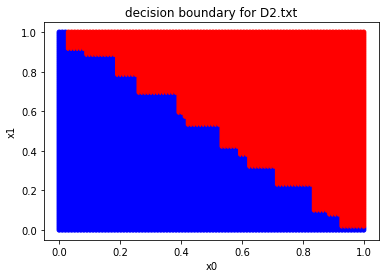

In [22]:
file = 'data/D2.txt'
df = pd.read_csv(file, sep=' ', header=None, names=['x0', 'x1', 'y'])
tree = Tree()
tree = make_subtree(df, tree, 'root', None)

pred = get_pred(tree, pred)
col = pred['pred'].map({0:'b', 1:'r'})
pred.plot.scatter('x0', 'x1', c=col, alpha=1)
plt.title('decision boundary for {}'.format(file.split('/')[1]))
plt.savefig('boundary/boundary_'+file.split('/')[1].split('.')[0]+'.png')
plt.show()

#### QUESTION 7

In [23]:
def get_accuracy(pred):
    acc = (pred['y'] == pred['pred']).mean()
    return acc

In [24]:
df = pd.read_csv('data/Dbig.txt', sep=' ', header=None, names=['x0', 'x1', 'y'])
df = df.sample(frac=1)

In [25]:
# ns = [32, 128, 512, 2048, 8129]
# for n in ns:
#     col = df[:n]['y'].map({0:'b', 1:'r'})
#     df[:n].plot.scatter('x0', 'x1', c=col, alpha=1);

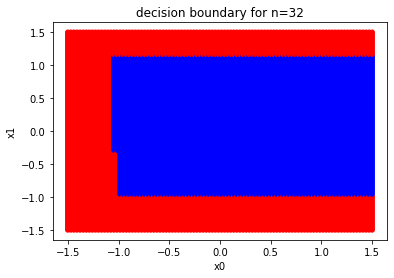

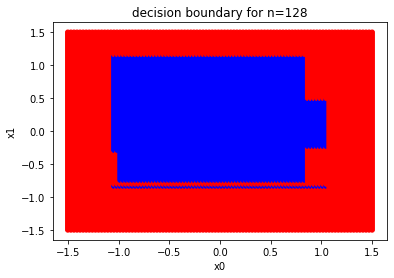

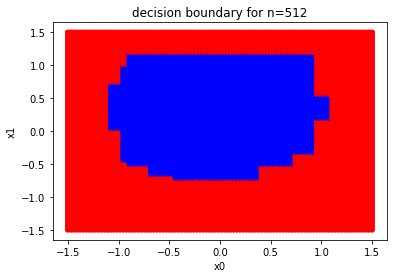

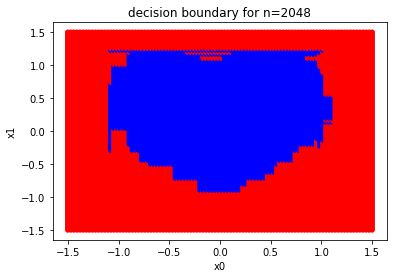

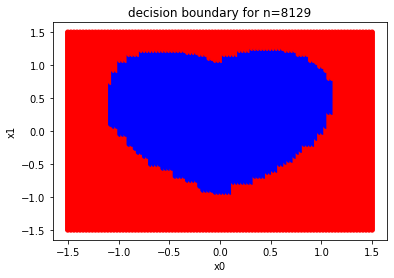

In [26]:
pd.options.mode.chained_assignment = None

new_poins = []
for i in np.linspace(-1.5, 1.5, 100):
    for j in np.linspace(-1.5, 1.5, 100):
        new_poins.append((i, j))
mesh = pd.DataFrame(new_poins, columns = ['x0', 'x1'])

ns = [32, 128, 512, 2048, 8129]
errors = []
sizes = []
for n in ns:
    tree = Tree()
    # tree.create_node("data", "data")
    tree = make_subtree(df[:n], tree, 'data', None)
    
    
    pred = get_pred(tree, df[8129:])
    acc = get_accuracy(pred)
    errors.append(1-acc)
    sizes.append(tree.size())
    
    pred = get_pred(tree, mesh)
    col = pred['pred'].map({0:'b', 1:'r'})
    pred.plot.scatter('x0', 'x1', c=col, alpha=1)
    plt.title('decision boundary for n={}'.format(n))
    plt.savefig('boundary/boundary_{}.png'.format(n))
    plt.show()

In [27]:
# errors = []
# ns = [32, 128, 512, 2048, 8129]
# sizes = []
# for n in ns:
#     tree = Tree()
#     # tree.create_node("data", "data")
#     tree = make_subtree(df[:n], tree, 'data', None)
#     pred = get_pred(tree, df[8129:])
#     acc = get_accuracy(pred)
#     errors.append(1-acc)
#     sizes.append(tree.size())

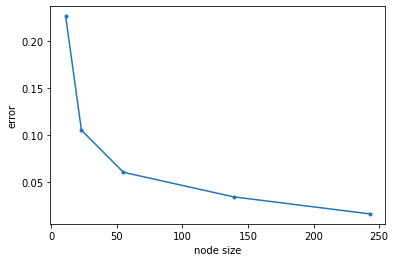

In [28]:
plt.plot(sizes, errors, marker='.')
plt.xlabel('node size')
plt.ylabel('error')
plt.show();

In [29]:
pd.DataFrame([ns,sizes, errors], index=['size','nodes', 'error']).T

,size,nodes,error
0,32.0,11.0,0.226617
1,128.0,23.0,0.105291
2,512.0,55.0,0.060396
3,2048.0,139.0,0.034206
4,8129.0,243.0,0.016034


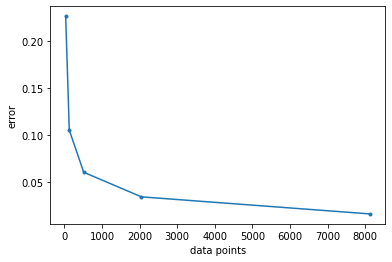

In [30]:
plt.plot(ns, errors, marker='.')
plt.xlabel('data points')
plt.ylabel('error')
plt.savefig('learning_curve.png')
plt.show();

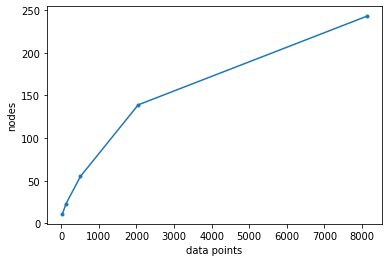

In [31]:
plt.plot(ns, sizes, marker='.')
plt.xlabel('data points')
plt.ylabel('nodes')
plt.show();

# Part 3

In [32]:
from sklearn.tree import DecisionTreeClassifier

errors_clf = []
node_counts = []
clfs = []
for n in ns:
    clf = DecisionTreeClassifier(random_state=5, criterion='entropy')
    clf.fit(df.iloc[:n][['x0', 'x1']], df.iloc[:n]['y'])
    acc = clf.score(df[8129:][['x0', 'x1']], df[8129:]['y'])
    clfs.append(clf)
    errors_clf.append(1-acc)
    node_counts.append(clf.tree_.node_count)

In [33]:
node_counts, errors_clf

pd.DataFrame([ns,node_counts, errors_clf], index=['size','nodes', 'error']).T

,size,nodes,error
0,32.0,9.0,0.211652
1,128.0,21.0,0.089792
2,512.0,47.0,0.047034
3,2048.0,107.0,0.022448
4,8129.0,221.0,0.011758


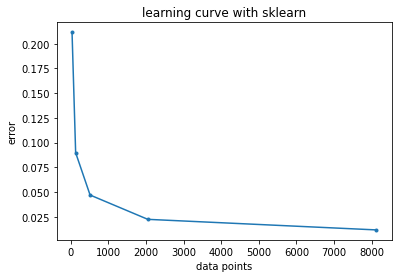

In [34]:
plt.plot(ns, errors_clf, marker='.');
plt.xlabel('data points')
plt.ylabel('error')
plt.title('learning curve with sklearn')
plt.savefig('learning_curve_sklearn.png')

# plt.plot(ns, node_counts, marker='.');

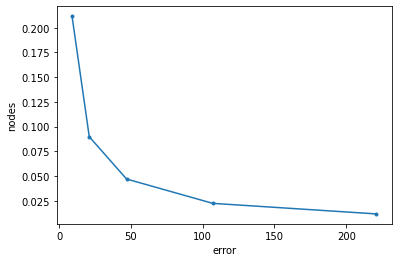

In [35]:
plt.plot(node_counts, errors_clf, marker='.')
plt.xlabel('error')
plt.ylabel('nodes')
plt.show();

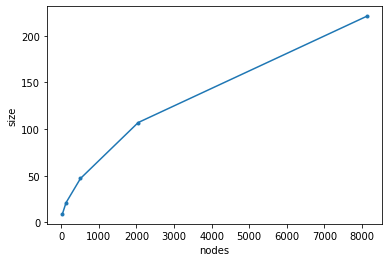

In [36]:
plt.plot(ns, node_counts, marker='.')
plt.xlabel('nodes')
plt.ylabel('size')
plt.show();

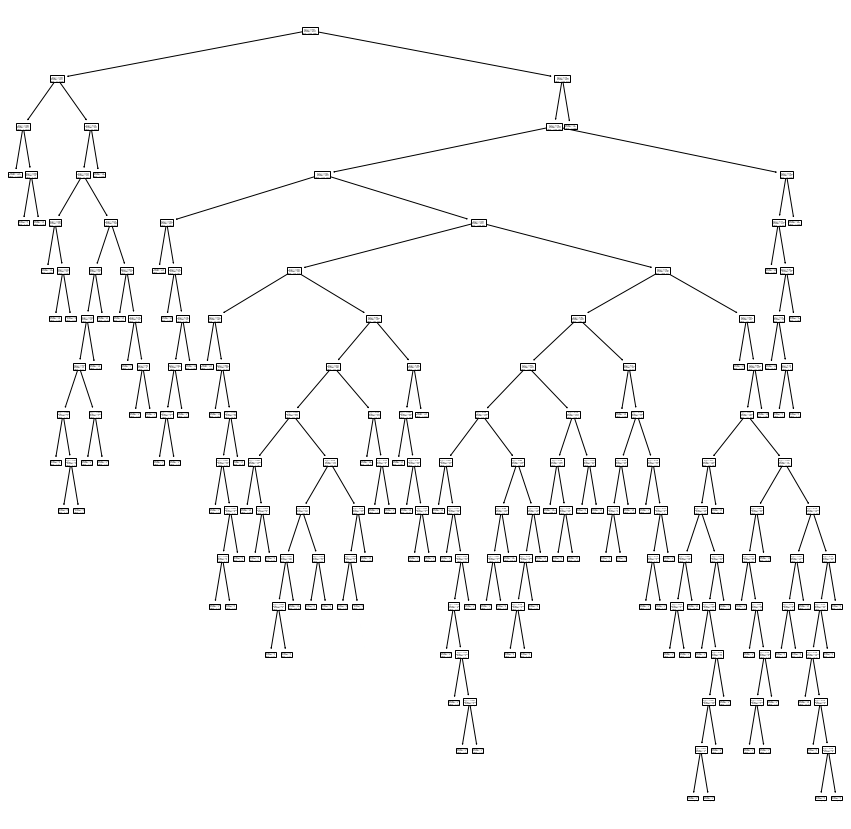

In [37]:
from sklearn.tree import plot_tree
plt.figure(figsize=(15, 15))
plot_tree(clfs[4])
plt.show()

# SECTION 4

In [38]:
from scipy.interpolate import lagrange
a, b = 0, 4*np.pi
n_points = 15

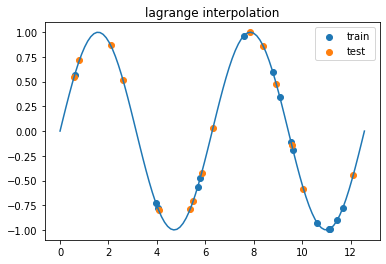

MSE: 4.070657727937538e-05


In [56]:
x = sorted(np.random.uniform(a, b, n_points))
# x = sorted(np.random.uniform(a, b, 19))
y = np.sin(x)
poly = lagrange(x, y)

plt.scatter(x, y, label = 'train')
plt.plot(np.linspace(a, b, 100), np.sin(np.linspace(a, b, 100)))

x_test = sorted(np.random.uniform(a, b, n_points))
y_pred = poly(x_test)
y_true = np.sin(x_test)
plt.scatter(x_test, y_pred, label = 'test')

plt.legend()
plt.title('lagrange interpolation')
plt.savefig('lagrange.png')
plt.show();

MSE = np.square(np.subtract(y_true,y_pred)).mean()
print('MSE:', MSE)

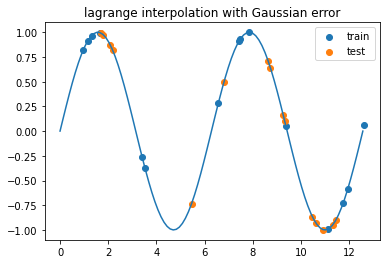

MSE: 3.809099923993532e-10


In [59]:
x = sorted(np.random.uniform(a, b, n_points))
noise = np.random.normal(loc=0.0, scale=1.0, size=n_points)
x+=noise
x = sorted(x)
# x = sorted(np.random.uniform(a, b, 19))
y = np.sin(x)
poly = lagrange(x, y)
plt.plot(np.linspace(a, b, 100), np.sin(np.linspace(a, b, 100)))

plt.scatter(x, y, label = 'train')

x_test = sorted(np.random.uniform(a, b, n_points))
# noise = np.random.normal(loc=0.0, scale=1.0, size=n_points)
x_test+=noise
x_test = sorted(x_test)
y_pred = poly(x_test)
y_true = np.sin(x_test)
plt.scatter(x_test, y_pred, label = 'test')

plt.legend()
plt.title('lagrange interpolation with Gaussian error')
plt.savefig('lagrange_error.png')
plt.show();

MSE = np.square(np.subtract(y_true,y_pred)).mean()
print('MSE:', MSE)